In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
class MultiLabelBinarizer_lsb(object):
    def __init__(self):
        self.mlb_dict = {}
        self.mlb_encode_size = {}
        self.encode_list = []
        self.col_name_list=[]
        
    def fit(self, X, encode_list):
        self.encode_list = encode_list
        self.col_name_list = X.columns.values.tolist()
        shape_x, shape_y = X.shape
        new_X = pd.DataFrame(np.zeros((shape_x, 1)),columns=['zero'])
        size_index = 0
        for index,col_cat in enumerate(encode_list):
            if col_cat == 0:
                new_X = pd.concat([new_X, X.iloc[:,index]], axis=1)   #横向拼接
                self.mlb_encode_size[index] = (size_index, size_index+1)
                size_index += 1
            else:
                self.mlb_dict[index] = MultiLabelBinarizer()
                col_encoded = pd.DataFrame(self.mlb_dict[index].fit_transform(X.iloc[:,index].values.reshape(-1,1)))
                new_X = pd.concat([new_X, col_encoded], axis=1)
                _, encoded_size = col_encoded.shape
                self.mlb_encode_size[index] = (size_index, size_index+encoded_size)
                size_index += encoded_size
        new_X.drop(['zero'],axis=1,inplace=True)
        return new_X
    
    def transform(self, X):
        encode_list = self.encode_list
        shape_x, shape_y = X.shape
        new_X = pd.DataFrame(np.zeros((shape_x, 1)),columns=['zero'])
        size_index = 0
        for index,col_cat in enumerate(encode_list):
            if col_cat == 0:
                new_X = pd.concat([new_X, X.iloc[:,index]], axis=1)   #横向拼接
                size_index += 1
            else:
                col_encoded = pd.DataFrame(self.mlb_dict[index].transform(X.iloc[:,index].values.reshape(-1,1)))
                new_X = pd.concat([new_X, col_encoded], axis=1)
                _, encoded_size = col_encoded.shape
                #self.mlb_encode_size[index] = (size_index, size_index+encoded_size)
                size_index += encoded_size
        new_X.drop(['zero'],axis=1,inplace=True)
        return new_X
    
    def inverse_transform(self, encode_X):
        encode_list = self.encode_list
        shape_x, shape_y = encode_X.shape
        new_X = pd.DataFrame(np.zeros((shape_x, 1)),columns=['zero'])
        for index,col_cat in enumerate(encode_list):
            if col_cat == 0:
                start_index, end_index = self.mlb_encode_size[index]
                #print(encode_X.iloc[:,start_index:end_index])
                new_X = pd.concat([new_X, encode_X.iloc[:,start_index:end_index]], axis=1)   #横向拼接
            else:
                mlb = self.mlb_dict[index]
                start_index, end_index = self.mlb_encode_size[index]
                to_inverse_X = np.array(encode_X.iloc[:, start_index:end_index])
                inverse_X = pd.DataFrame(mlb.inverse_transform(to_inverse_X))
                #print(inverse_X)
                new_X = pd.concat([new_X, inverse_X], axis=1)
                #self.mlb_encode_size[index] = (size_index, size_index+encoded_size)
        new_X.drop(['zero'],axis=1,inplace=True)
        print(new_X.shape)
        new_X.columns = self.col_name_list
        return new_X

In [8]:
def float_to_oh(sample_list):
    sample_list = sample_list.reshape(1,-1)
    #print(sample_list.shape)
    max_num = 0
    max_index = 0
    for index in range(1,4):
        
        #print("sample_list[0,"+str(index)+'] is'+str(sample_list[0,index]) )
        if sample_list[0,index] > max_num:
            #print("set")
            max_index = index
            max_num = sample_list[0,index]
    #print(max_index)
    #print(max_num)
    for index in range(1,4):
        if index == max_index:
            sample_list[0,index] = 1
        else:
            sample_list[0,index] = 0
    
    max_num = -1
    max_index = 0
    for index in range(4,70):
        
        if sample_list[0,index] > max_num:
            max_index = index
            max_num = sample_list[0,index]
    
    for index in range(4,70):
        if index == max_index:
            sample_list[0,index] = 1
        else:
            sample_list[0,index] = 0
            
    max_num = 0
    max_index = 0
    for index in range(70,81):
        if sample_list[0,index] > max_num:
            max_index = index
            max_num = sample_list[0,index]
    
    for index in range(70,81):
        if index == max_index:
            sample_list[0,index] = 1
        else:
            sample_list[0,index] = 0
    return sample_list

In [9]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [10]:
import numpy as np
import pandas as pd

df_info = pd.read_csv('kddcup.names',sep=":",skiprows=1, index_col=False, names=['colname','type'])
colnames = df_info.colname.values
coltypes = np.where(df_info["type"].str.contains("continuous"), "float", "str")
colnames = np.append(colnames, ["status"])

df = pd.read_csv('kddcup.data_10_percent.gz',names=colnames, index_col=False,
                    dtype=dict(zip(colnames,coltypes)))

In [11]:
df.loc[df["status"] != "normal.", 'type'] = 0
df.loc[df["status"] == "normal.", 'type'] = 1
df = df.drop(['status'], axis=1)

In [12]:
cat_list = []
for i in range(41):
    if i == 1 or i == 2 or i == 3:
        cat_list.append(1)
    else:
        cat_list.append(0)

In [13]:
my_lsb = MultiLabelBinarizer_lsb()
new_df = my_lsb.fit(df.iloc[:,:-1], cat_list)

In [1]:
import tensorflow as tf
import architecture.Dagmm as dagmm
import sys
import general.stat_lib as lib

In [2]:
#filename = "demo/kddcup99-10.data.pp.csv.gz"
filename = "lsb.csv.gz"
cnet_config = [118,
               60,
               30,
               10,
               1]
enet_config = {'general': [3, 4, 1],
               'layer_1': [10]}
precision = 0
recall = 0
f1 = 0
rounds = 1
epoch = 200
threshold = 0.2
batch_size = 1024
step = 1

tf.reset_default_graph()
machine = dagmm.DAGMM(118, cnet_config, enet_config)
data = machine.get_kddcup_data(filename)

all: 494021; outlier: 97278; ratio: 0.196911


In [3]:
epoch = 200

Epoch 1: objective 10.848; error 4.97527; mix loss -5.58225; dev penalty 1286.2
Epoch 2: objective 6.07459; error 3.31719; mix loss -3.9143; dev penalty 629.766
Epoch 3: objective 3.60924; error 1.79664; mix loss -1.40385; dev penalty 390.598
Epoch 4: objective 2.90404; error 1.66607; mix loss -1.18795; dev penalty 271.352
Epoch 5: objective 2.53148; error 1.64203; mix loss -1.1655; dev penalty 201.199
Epoch 6: objective 2.28295; error 1.62411; mix loss -1.18188; dev penalty 155.406
Epoch 7: objective 2.091; error 1.60222; mix loss -1.28175; dev penalty 123.393
Epoch 8: objective 1.92865; error 1.5682; mix loss -1.43616; dev penalty 100.813
Epoch 9: objective 1.76436; error 1.50242; mix loss -1.60645; dev penalty 84.518
Epoch 10: objective 1.51541; error 1.34262; mix loss -1.83643; dev penalty 71.2876
Epoch 11: objective 0.999645; error 0.987665; mix loss -2.76349; dev penalty 57.6657
Epoch 12: objective 0.743542; error 0.777855; mix loss -2.91039; dev penalty 51.3451
Epoch 13: objecti

Epoch 98: objective -0.502926; error 0.360482; mix loss -9.34059; dev penalty 14.1302
Epoch 99: objective -0.6175; error 0.359474; mix loss -10.4635; dev penalty 13.8752
Epoch 100: objective -0.643694; error 0.359131; mix loss -10.7209; dev penalty 13.8524
Epoch 101: objective -0.582576; error 0.360252; mix loss -10.1298; dev penalty 14.0307
Epoch 102: objective -0.616541; error 0.361001; mix loss -10.4774; dev penalty 14.04
Epoch 103: objective -0.539135; error 0.361638; mix loss -9.70308; dev penalty 13.9069
Epoch 104: objective -0.604861; error 0.35859; mix loss -10.3295; dev penalty 13.9004
Epoch 105: objective -0.643627; error 0.360556; mix loss -10.7389; dev penalty 13.9419
Epoch 106: objective -0.642789; error 0.355274; mix loss -10.6645; dev penalty 13.6783
Epoch 107: objective -0.652165; error 0.357779; mix loss -10.7907; dev penalty 13.8253
Epoch 108: objective -0.495155; error 0.361524; mix loss -9.24808; dev penalty 13.6256
Epoch 109: objective -0.533208; error 0.356586; mi

Epoch 193: objective -0.736831; error 0.322818; mix loss -11.1988; dev penalty 12.0453
Epoch 194: objective -0.663651; error 0.319535; mix loss -10.4412; dev penalty 12.1872
Epoch 195: objective -0.810033; error 0.317229; mix loss -11.8945; dev penalty 12.4376
Epoch 196: objective -0.795163; error 0.317134; mix loss -11.7428; dev penalty 12.3967
Epoch 197: objective -0.654933; error 0.317987; mix loss -10.3305; dev penalty 12.0261
Epoch 198: objective -0.66239; error 0.316116; mix loss -10.4034; dev penalty 12.3667
Epoch 199: objective -0.72496; error 0.316491; mix loss -11.0312; dev penalty 12.3349
Epoch 200: objective -0.752871; error 0.314292; mix loss -11.2952; dev penalty 12.4724


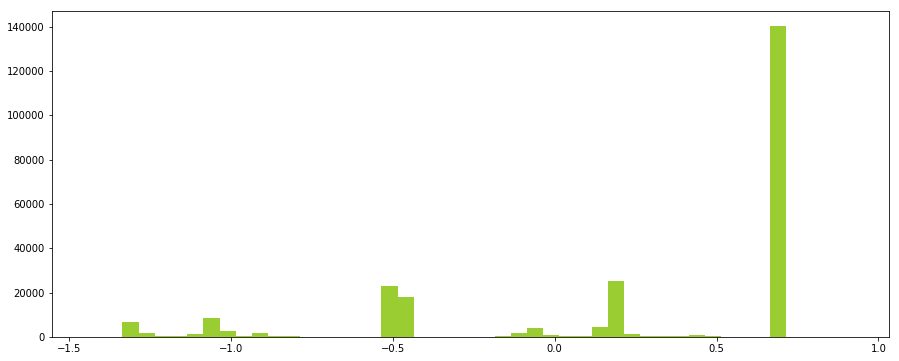

In [ ]:
p, r, f, new_sample_left, new_sample_center, new_sample_right, test_latent_index = machine.run(data, epoch, threshold, batch_size, step)
# new_sample_left, new_sample_center, new_sample_right, my_train_zo 
precision = precision + p
recall = recall + r
f1 = f1 + f
print("avg. precision: %g; avg. recall: %g; avg. f1: %g" % (precision / rounds, recall / rounds, f1 / rounds))

In [23]:
for index in range(500):
    new_sample_left[index, :] = float_to_oh(new_sample_left[index, :])
for index in range(500):
    new_sample_center[index, :] = float_to_oh(new_sample_center[index, :])
for index in range(500):
    new_sample_right[index, :] = float_to_oh(new_sample_right[index, :])
for index in range(len(test_center)):
    test_center[index, :] = float_to_oh(test_center[index, :])

In [24]:
pd_new_sample_left=pd.DataFrame(new_sample_left)
pd_new_sample_center=pd.DataFrame(new_sample_center)
pd_new_sample_right=pd.DataFrame(new_sample_right)
pd_test_center = pd.DataFrame(test_center)

In [25]:
for i in range(1,81):
    pd_new_sample_left[i] = pd_new_sample_left[i].astype('int')
    pd_new_sample_center[i] = pd_new_sample_center[i].astype('int')
    pd_new_sample_right[i] = pd_new_sample_right[i].astype('int')
    pd_test_center[i] = pd_test_center[i].astype('int')

In [26]:
inverse_sample_left = my_lsb.inverse_transform(pd_new_sample_left)
inverse_sample_center = my_lsb.inverse_transform(pd_new_sample_center)
inverse_sample_right = my_lsb.inverse_transform(pd_new_sample_right)
inverse_test_center = my_lsb.inverse_transform(pd_test_center)

(500, 41)
(500, 41)
(500, 41)
(63009, 41)


In [18]:
inverse_sample_center.head(500)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.000000,tcp,private,REJ,0.000000e+00,223651.784659,0.000000,0.370956,0.081929,0.000000,...,341.123041,96.433023,0.651723,0.216094,0.746520,0.000000,0.138254,0.150633,0.888229,1.021234
1,0.000000,icmp,ecr_i,SF,0.000000e+00,176283.622078,0.000000,0.329818,0.030867,0.000000,...,295.267980,170.636453,0.848330,0.145105,0.926070,0.000000,0.017221,0.020861,0.451999,0.537608
2,588.979877,tcp,private,REJ,8.205400e+06,0.000000,0.008782,0.023593,0.000000,0.395821,...,365.046116,30.711828,0.280213,0.139215,0.213591,0.024512,0.571246,0.575152,1.067730,1.051734
3,8.666469,icmp,ecr_i,SF,0.000000e+00,85757.891042,0.000000,0.175580,0.006819,0.000000,...,271.375335,216.726182,0.934897,0.070542,0.972908,0.000000,0.000000,0.000000,0.202529,0.238351
4,0.000000,tcp,private,REJ,0.000000e+00,227333.063330,0.000000,0.394925,0.065443,0.000000,...,322.200145,124.830197,0.740139,0.199299,0.840156,0.000000,0.073987,0.081909,0.712446,0.838527
5,0.000000,icmp,ecr_i,SF,0.000000e+00,182800.750509,0.000000,0.339682,0.033684,0.000000,...,297.528719,166.542326,0.839784,0.150905,0.920422,0.000000,0.020631,0.024534,0.474547,0.564429
6,0.000000,icmp,ecr_i,SF,0.000000e+00,133153.581032,0.000000,0.259932,0.016605,0.000000,...,282.655008,194.321467,0.894754,0.108722,0.953466,0.000000,0.002501,0.004907,0.323115,0.383157
7,0.000000,tcp,ecr_i,SF,0.000000e+00,221995.611060,0.000000,0.391099,0.058789,0.000000,...,316.814403,133.474335,0.763085,0.191141,0.861019,0.000000,0.059689,0.066540,0.661571,0.781790
8,326.134491,tcp,private,REJ,4.942190e+06,0.000000,0.004134,0.042291,0.000000,0.306003,...,369.777062,33.687226,0.305640,0.146595,0.248208,0.020100,0.529723,0.535642,1.116057,1.109487
9,0.000000,tcp,private,REJ,0.000000e+00,120332.454125,0.000000,0.208565,0.050362,0.000000,...,369.331232,57.142379,0.470107,0.194797,0.497199,0.000000,0.310264,0.326772,1.140719,1.215965


In [21]:
test_center = data.test_data[test_latent_index]

In [30]:
inverse_test_center.to_csv('inverse_test_center.csv',index=False,float_format='%.4f')
inverse_sample_center.to_csv('inverse_sample_center.csv',index=False,float_format='%.4f')